## 预处理数据

In [1]:
import  torch
from src.utils.visualize import plot_visium_overlay

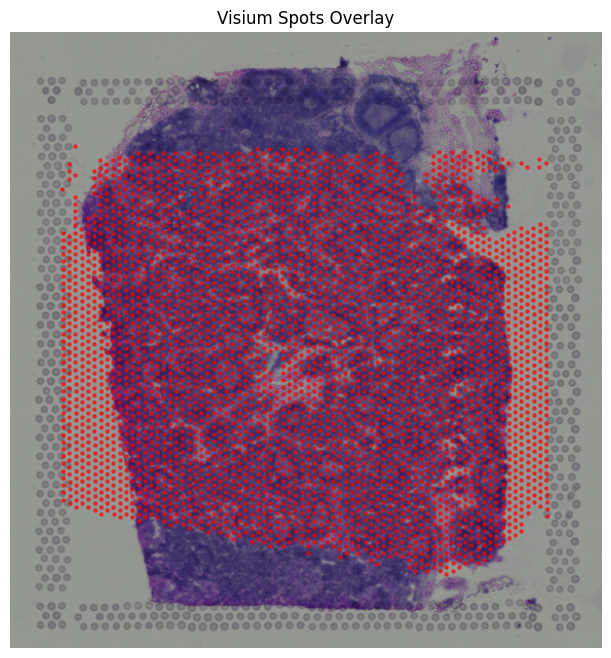

In [2]:

data = torch.load("../data/E1_slide1.pt", weights_only=False)

plot_visium_overlay(
    data,
    img_path="../data/Visium_Human_Lymph_Node/spatial/tissue_lowres_image.png",
    scalefactors_path="../data/Visium_Human_Lymph_Node/spatial/scalefactors_json.json",
    use_hires=False
)

In [3]:
import pandas as pd
features = pd.read_csv("../data/Visium_Human_Lymph_Node/filtered_feature_bc_matrix/features.tsv.gz",
                       sep="\t", header=None)
print(features.head(20))
print(features[1].unique()[:20])  # 打印前20个 gene symbol

                  0            1                2
0   ENSG00000243485  MIR1302-2HG  Gene Expression
1   ENSG00000237613      FAM138A  Gene Expression
2   ENSG00000186092        OR4F5  Gene Expression
3   ENSG00000238009   AL627309.1  Gene Expression
4   ENSG00000239945   AL627309.3  Gene Expression
5   ENSG00000239906   AL627309.2  Gene Expression
6   ENSG00000241860   AL627309.5  Gene Expression
7   ENSG00000241599   AL627309.4  Gene Expression
8   ENSG00000286448   AP006222.2  Gene Expression
9   ENSG00000236601   AL732372.1  Gene Expression
10  ENSG00000284733       OR4F29  Gene Expression
11  ENSG00000235146   AC114498.1  Gene Expression
12  ENSG00000284662       OR4F16  Gene Expression
13  ENSG00000229905   AL669831.2  Gene Expression
14  ENSG00000237491    LINC01409  Gene Expression
15  ENSG00000177757       FAM87B  Gene Expression
16  ENSG00000228794    LINC01128  Gene Expression
17  ENSG00000225880    LINC00115  Gene Expression
18  ENSG00000230368       FAM41C  Gene Expression


## 初始静态L-R通信强度

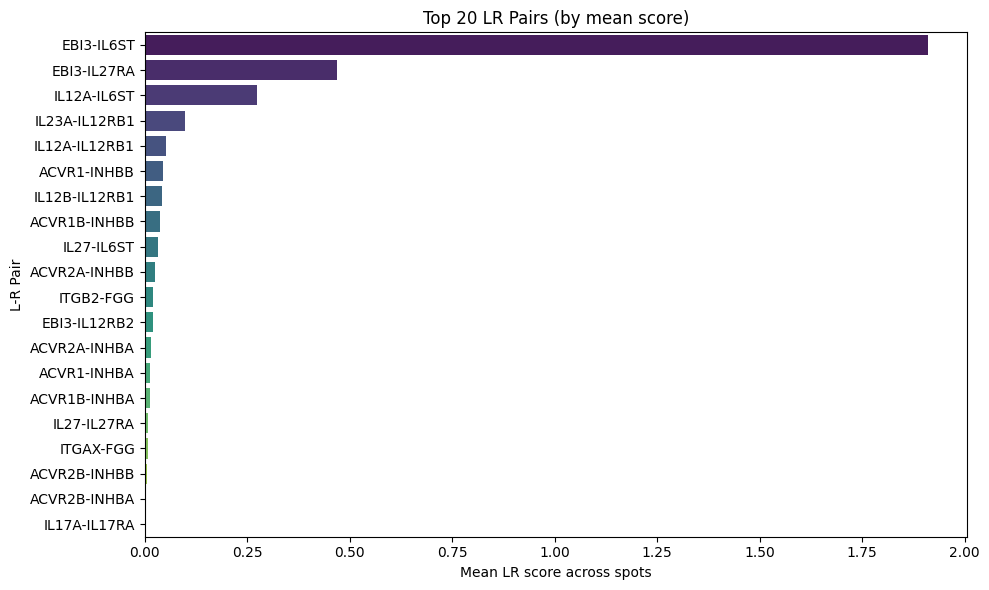

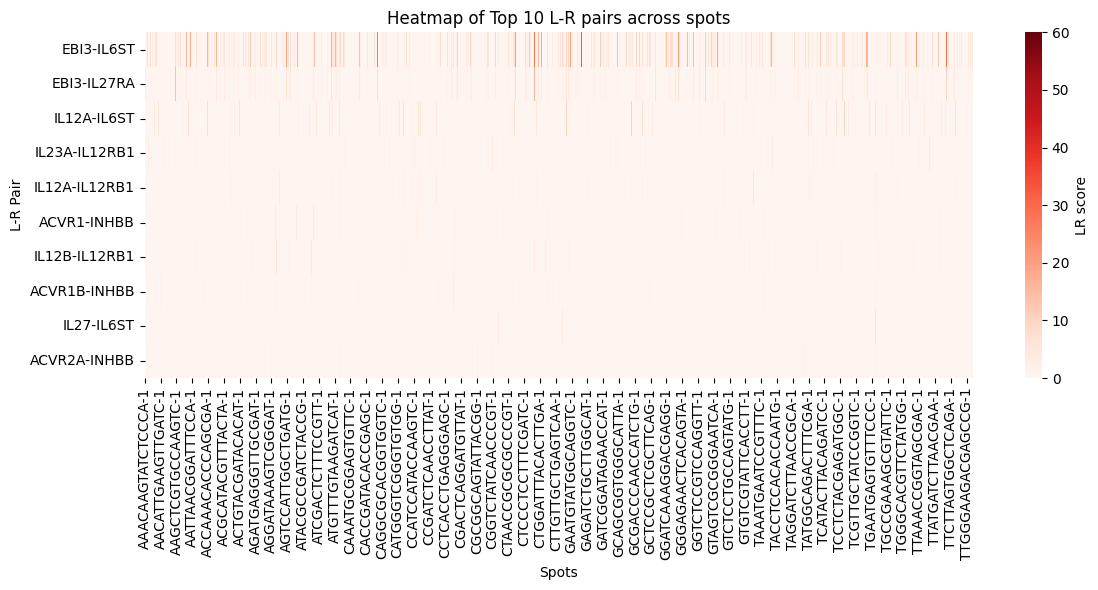

In [4]:
from src.utils.analysis import plot_lr_activity

adata_path = "../data/Visium_Human_Lymph_Node/filtered_feature_bc_matrix"
lr_pairs_path = "../data/lr_pairs_1.csv"

df_scores = plot_lr_activity(adata_path, lr_pairs_path, top_n=20, heatmap=True)


## 生成图的数据格式

In [2]:
import torch

# 路径改成你的 pt 文件位置
pt_path = "../data/with_edge_attr/Human_Breast_Cancer_with_edge_attr.pt"

# 1. 读文件
data = torch.load(pt_path, weights_only=False)

# 2. 打印整体 Data 对象
print(data)

# 3. 分别打印字段信息
print("x shape:", data.x.shape)                 # PCA 特征
print("edge_index shape:", data.edge_index.shape) # 图边
print("pos shape:", data.pos.shape)             # 空间坐标
print("raw_expr shape:", data.raw_expr.shape)   # 基因表达矩阵
print("gene_names length:", len(data.gene_names))

# 4. 看一小部分数据
print("前5个基因名:", data.gene_names[:5])
print("前5条边:", data.edge_index[:, :5])
print("第一个spot的PCA特征:", data.x[0, :10])   # 只打印前10维
print("第一个spot的基因表达:", data.raw_expr[0, :10])  # 只打印前10个基因
print("第一个spot坐标:", data.pos[0])


Data(x=[4898, 256], edge_index=[2, 29388], pos=[4898, 2], raw_expr=[4898, 36601], gene_names=[36601], edge_attr=[29388, 2])
x shape: torch.Size([4898, 256])
edge_index shape: torch.Size([2, 29388])
pos shape: torch.Size([4898, 2])
raw_expr shape: torch.Size([4898, 36601])
gene_names length: 36601
前5个基因名: ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3']
前5条边: tensor([[4196, 2649, 1126, 1890, 4734],
        [4678, 4314, 1126, 4262, 1055]])
第一个spot的PCA特征: tensor([ 5.0333,  2.6614, -1.7403, -0.2057,  0.1498, -1.6831,  1.8506, -0.6515,
        -0.1846, -0.3911])
第一个spot的基因表达: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
第一个spot坐标: tensor([ 4662., 14376.])


In [14]:
import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors

def graph_stats(coords, k):
    """
    根据坐标构建 kNN 图，并统计连通性、孤点等信息
    coords: ndarray [N,2]  spot 坐标
    k: int  kNN 邻居数
    """
    # 构建 kNN 邻居
    nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
    coo = nbrs.kneighbors_graph(coords).tocoo()
    E = np.vstack([coo.row, coo.col])   # shape (2, E)


    G = nx.from_edgelist(E.T)
    n = coords.shape[0]

    # 连通分量
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    gcc_frac = len(comps[0]) / n  # 最大连通分量占比
    isolates = sum(1 for c in comps if len(c) == 1)  # 孤点数
    avg_deg = sum(dict(G.degree()).values()) / n

    return {
        "k": k,
        "nodes": n,
        "edges": G.number_of_edges(),
        "avg_deg": round(avg_deg, 2),
        "GCC_frac": round(gcc_frac, 4),
        "isolates": isolates
    }


if __name__ == "__main__":
    import torch
    data = torch.load("../data/processed_graphs/Human_Lung_Tissue.pt", weights_only=False)
    coords = data.pos.numpy()

    for k_try in [6, 8, 10, 12, 15]:
        stats = graph_stats(coords, k_try)
        print(stats)

{'k': 6, 'nodes': 6195, 'edges': 22873, 'avg_deg': 7.38, 'GCC_frac': 1.0, 'isolates': 0}
{'k': 8, 'nodes': 6195, 'edges': 29031, 'avg_deg': 9.37, 'GCC_frac': 1.0, 'isolates': 0}
{'k': 10, 'nodes': 6195, 'edges': 35670, 'avg_deg': 11.52, 'GCC_frac': 1.0, 'isolates': 0}
{'k': 12, 'nodes': 6195, 'edges': 41788, 'avg_deg': 13.49, 'GCC_frac': 1.0, 'isolates': 0}
{'k': 15, 'nodes': 6195, 'edges': 51064, 'avg_deg': 16.49, 'GCC_frac': 1.0, 'isolates': 0}


Data(x=[4035, 256], edge_index=[2, 27906], pos=[4035, 2], raw_expr=[4035, 36601], gene_names=[36601])


C:\Users\Drton1\PycharmProjects\SpatialSelf\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


 UMAP embedding saved to ../figs/umap_embedding.png
 Graph overlay saved to ../figs/graph_overlay.png


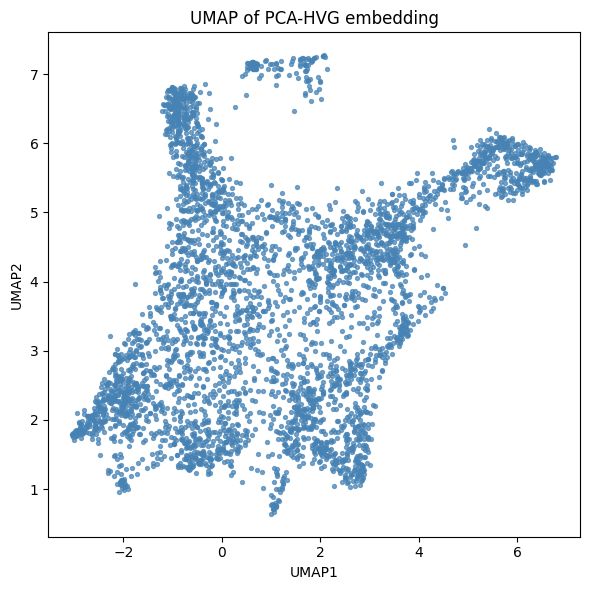

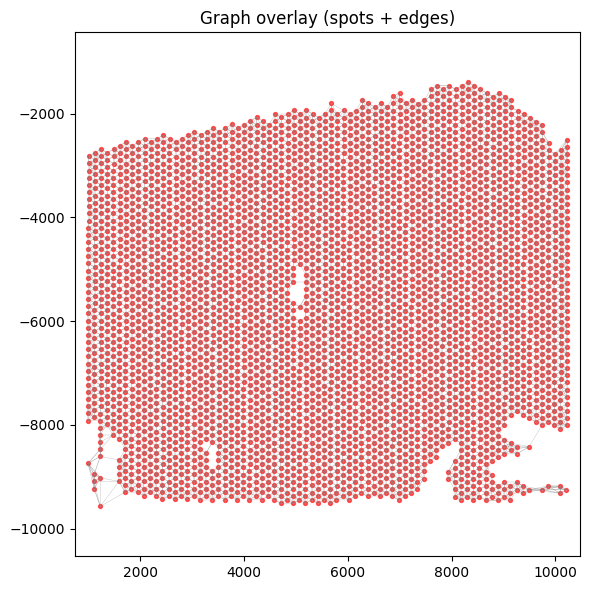

In [16]:
import torch
import matplotlib.pyplot as plt
import umap
import numpy as np

pt_path = "../data/processed_graphs/Visium_Human_Lymph_Node.pt"
data = torch.load(pt_path, weights_only=False)

print(data)


#1UMAP 可视化 HVG PCA

X_pca = data.x.numpy()   # 节点特征 (PCA)
coords = data.pos.numpy() # 空间坐标 (x, y)

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

plt.figure(figsize=(6,6))
plt.scatter(X_umap[:,0], X_umap[:,1], s=8, c="steelblue", alpha=0.7)
plt.title("UMAP of PCA-HVG embedding")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.tight_layout()
plt.savefig("../figs/umap_embedding.png", dpi=300)
print(" UMAP embedding saved to ../figs/umap_embedding.png")


plt.figure(figsize=(6,6))

# 画节点
plt.scatter(coords[:,0], -coords[:,1], s=8, c="red", alpha=0.6)  # -y 翻转方向以对齐组织

# 画边
edge_index = data.edge_index.numpy()
for i,j in edge_index.T:
    x1, y1 = coords[i]
    x2, y2 = coords[j]
    plt.plot([x1, x2], [-y1, -y2], c="gray", linewidth=0.3, alpha=0.5)

plt.title("Graph overlay (spots + edges)")
plt.axis("equal"); plt.tight_layout()
plt.savefig("../figs/graph_overlay.png", dpi=300)
print(" Graph overlay saved to ../figs/graph_overlay.png")


In [2]:
import pandas as pd
df = pd.read_csv("../results/fold1_Lymph_top500.csv")
genes = set(df["Ligand"].tolist()) | set(sum([r.split("+") for r in df["Receptor(s)"]], []))
genes = [g for g in genes if g != "NA"]
pd.Series(genes).to_csv("lymph_highconf_genes.txt", index=False, header=False)


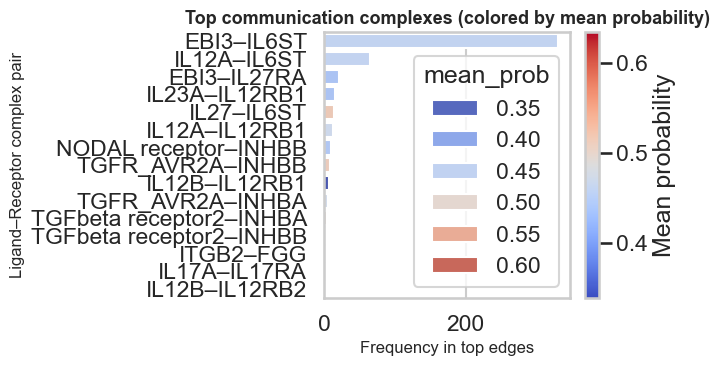


✅ 映射示例:
  Ligand     Ligand_complex Receptor(s) Receptor_complex
0   EBI3               EBI3       IL6ST            IL6ST
1  ACVR1  TGFbeta receptor2       INHBA            INHBA
2   EBI3               EBI3       IL6ST            IL6ST
3   EBI3               EBI3       IL6ST            IL6ST
4   EBI3               EBI3       IL6ST            IL6ST
5   EBI3               EBI3       IL6ST            IL6ST
6   EBI3               EBI3       IL6ST            IL6ST
7   EBI3               EBI3       IL6ST            IL6ST
8   EBI3               EBI3       IL6ST            IL6ST
9   EBI3               EBI3       IL6ST            IL6ST


In [11]:
# ============================================================
# 绘制复合体级 “Top communication complexes (colored by mean probability)”
# ============================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# -----------------------------
# 1. 路径设置
# -----------------------------
EDGE_PATH = "../results/fold1_Lymph_top500.csv"
COMPLEX_PATH = "../data/L-Rgene/complex_input.csv"

assert os.path.exists(EDGE_PATH), f"❌ 未找到边文件：{EDGE_PATH}"
assert os.path.exists(COMPLEX_PATH), f"❌ 未找到复合体定义：{COMPLEX_PATH}"

# -----------------------------
# 2. 读取数据
# -----------------------------
edges = pd.read_csv(EDGE_PATH)
complex_df = pd.read_csv(COMPLEX_PATH)

required_cols = {'Ligand', 'Receptor(s)', 'prob'}
if not required_cols.issubset(edges.columns):
    raise ValueError(f"缺少必要字段: {required_cols - set(edges.columns)}")

# -----------------------------
# 3. Uniprot → Gene Symbol 映射（核心修复）
# -----------------------------
# 常见受体、配体的 Uniprot 转换（可扩展）
uniprot_to_gene = {
    "P37023": "ACVL1",
    "Q13873": "BMPR2",
    "Q04771": "ACVR1",
    "P27037": "ACVR2A",
    "Q13705": "ACVR2B",
    "P36896": "ACVR1B",
    "Q8NER5": "ACVR1C",
}

def uniprot_to_symbol(uid):
    uid = str(uid).strip()
    return uniprot_to_gene.get(uid, uid)

# -----------------------------
# 4. 构造复合体映射字典（以基因符号为键）
# -----------------------------
complex_map = {}

for _, row in complex_df.iterrows():
    cname = str(row.get('complex_name', '')).strip()
    for col in ['uniprot_1', 'uniprot_2', 'uniprot_3', 'uniprot_4']:
        val = row.get(col)
        if pd.notna(val):
            gene = uniprot_to_symbol(val).upper()
            if gene:
                complex_map[gene] = cname

# -----------------------------
# 5. 应用映射到 edges
# -----------------------------
def map_to_complex(gene):
    gene = str(gene).upper().strip()
    return complex_map.get(gene, gene)

edges['Ligand_complex'] = edges['Ligand'].apply(map_to_complex)
edges['Receptor_complex'] = edges['Receptor(s)'].apply(map_to_complex)
edges['Complex_pair'] = edges['Ligand_complex'] + "–" + edges['Receptor_complex']

# -----------------------------
# 6. 统计频次和平均概率
# -----------------------------
pair_stats = (
    edges.groupby('Complex_pair')
    .agg(freq=('prob', 'count'), mean_prob=('prob', 'mean'))
    .sort_values('freq', ascending=False)
    .head(15)
    .reset_index()
)

# -----------------------------
# 7. 绘制图
# -----------------------------
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(7,4))

bar = sns.barplot(
    data=pair_stats,
    x='freq',
    y='Complex_pair',
    hue='mean_prob',
    dodge=False,
    palette='coolwarm'
)

plt.xlabel("Frequency in top edges", fontsize=12)
plt.ylabel("Ligand–Receptor complex pair", fontsize=12)
plt.title("Top communication complexes (colored by mean probability)", fontsize=13, weight='bold')

# ✅ 修复 colorbar 报错
norm = plt.Normalize(pair_stats['mean_prob'].min(), pair_stats['mean_prob'].max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label='Mean probability')

plt.tight_layout()
plt.show()

# -----------------------------
# 8. 调试输出，验证映射是否生效
# -----------------------------
print("\n✅ 映射示例:")
print(edges[['Ligand','Ligand_complex','Receptor(s)','Receptor_complex']].head(10))


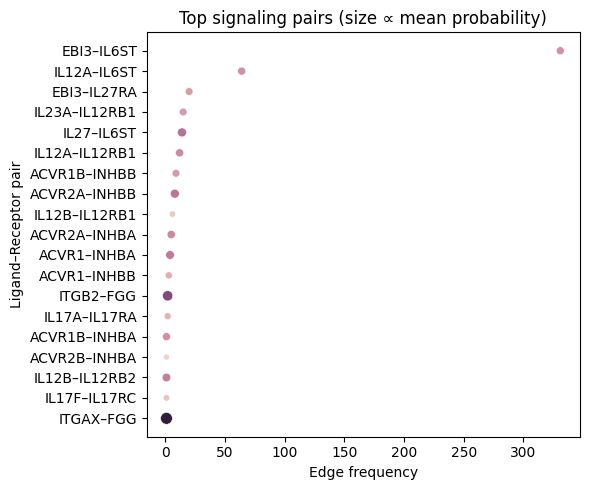

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../results/fold1_Lymph_top500.csv")
df["LR_pair"] = df["Ligand"] + "–" + df["Receptor(s)"]
# 统计每个配体–受体组合的出现次数和平均prob
stats = df.groupby("LR_pair").agg(
    freq=("prob","count"),
    mean_prob=("prob","mean")
).reset_index().sort_values("freq", ascending=False).head(20)

plt.figure(figsize=(6,5))
sns.scatterplot(data=stats, x="freq", y="LR_pair", size="mean_prob", hue="mean_prob", legend=False)
plt.xlabel("Edge frequency")
plt.ylabel("Ligand–Receptor pair")
plt.title("Top signaling pairs (size ∝ mean probability)")
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel("../results/fold1_Lymph_top500.csv")  # 改成你的文件
top = df.head(15)
plt.figure(figsize=(6,4))
sns.scatterplot(data=top, x=-np.log10(top["P-value"]), y=top["Description"], size="Gene Count", hue="Gene Count", legend=False)
plt.xlabel("-log10(p-value)")
plt.ylabel("Enriched pathway")
plt.title("Pathway enrichment of high-confidence LR genes")
plt.tight_layout()
plt.show()


ValueError: Excel file format cannot be determined, you must specify an engine manually.